# Description of the survey workflow

This example involves building a basic neural network to classify images and improving it through the InceptionV3 model. However, the goal was not to create a perfect classifier only to illustrate how a "Transfer learning" technique that aids in model building. The InceptionV3 model was used for this purpose, which was trained on data from the ImageNet dataset and showed 78.1% model accuracy. 

Transfer learning is designed to speed up model building, increase model performance, or flip knowledge when you have a small data set.

Thus, the InceptionV3 model was downloaded without the last layers responsible for classification. All downloaded layers were excluded from the learning process and their weights were frozen for use in model building. 

The premise of this approach is that convolutional neural networks extract certain patterns that are universal. These networks are typically designed to detect edges in the first layer, shapes in the middle layer, and specific features in the last layers. The initial and middle layers are used for transfer learning while the last layers responsible for specific features and classifications are changed. 

The downloaded InceptionV3 model replaced the input layer of the basic neural network created earlier, the rest of the layers in the built model remained unchanged.

# Imports

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.metrics import  confusion_matrix
import seaborn as sns
import os

# Prepare data to models
Taking image data and applying a series of random transformations to each image in the batch (including random rotation, resizing, shearing, etc.). Replacing the original batch with the new, randomly transformed batch. Training the CNN on this randomly transformed batch (i.e., the original data itself is not used for training).

In this example i used only 20 races. This is due to the length of the processed data in the local environment, so I decided to limit myself to 20 races.

Images were extracted from designated pathways. /train /test /validate. A breakdown of the collection can be found [here](https://github.com/Carleone82/uczenie_maszynowe_UEP_2022?fbclid=IwAR2sZW30W1VvpX9t9sGmDFQAG1_buzDXJHUuh2nCjQrnpJqFgJrs0bP3Etk).

In [4]:
# get categories
folder_path='Images'
folder_dir = os.listdir(folder_path)
dog_races=[]
for i in range(len(folder_dir)):
    index=folder_dir[i].index('-') 
    race=folder_dir[i][index+1:]
    dog_races.append(race)
dog_races

['Chihuahua',
 'Japanese_spaniel',
 'Maltese_dog',
 'Pekinese',
 'Shih-Tzu',
 'Blenheim_spaniel',
 'papillon',
 'toy_terrier',
 'Rhodesian_ridgeback',
 'Afghan_hound',
 'basset',
 'beagle',
 'bloodhound',
 'bluetick',
 'black-and-tan_coonhound',
 'Walker_hound',
 'English_foxhound',
 'redbone',
 'borzoi',
 'Irish_wolfhound',
 'Italian_greyhound',
 'whippet',
 'Ibizan_hound',
 'Norwegian_elkhound',
 'otterhound',
 'Saluki',
 'Scottish_deerhound',
 'Weimaraner',
 'Staffordshire_bullterrier',
 'American_Staffordshire_terrier',
 'Bedlington_terrier',
 'Border_terrier',
 'Kerry_blue_terrier',
 'Irish_terrier',
 'Norfolk_terrier',
 'Norwich_terrier',
 'Yorkshire_terrier',
 'wire-haired_fox_terrier',
 'Lakeland_terrier',
 'Sealyham_terrier',
 'Airedale',
 'cairn',
 'Australian_terrier',
 'Dandie_Dinmont',
 'Boston_bull',
 'miniature_schnauzer',
 'giant_schnauzer',
 'standard_schnauzer',
 'Scotch_terrier',
 'Tibetan_terrier',
 'silky_terrier',
 'soft-coated_wheaten_terrier',
 'West_Highland_wh

In [ ]:
# function, thanks to which we distribute sets into appropriate folders
def sort_images(df,type_of_data:str):
    race_folder_created=[]
    for directory in df.Directory:
        index=directory.split('/')[-2].index('-')
        race=directory.split('/')[-2][index+1:]
        if race not in race_folder_created:
            os.mkdir(f'Images_sorted/{type_of_data}/{race}')
            race_folder_created.append(race)
        shutil.copy2(directory, f"Images_sorted/{type_of_data}/{race}/{directory.split('/')[-1]}")

In [ ]:
# allocate images to appropriate folders
files=['test','train','validate']
for file in files:
    df=pd.read_csv(file+'.csv')
    sort_images(df,file)

In [5]:
#prepare the images
dog_races=dog_races[:20]
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                            brightness_range=(0.5,1), 
                            channel_shift_range=0.2,
                            horizontal_flip=True,
                            vertical_flip=True,
                            rescale=1./255)
img_generator_flow_train = img_generator.flow_from_directory(
    directory='Images_sorted/train',
    target_size=(224, 224),
    batch_size=16,
    shuffle=True,
    classes=dog_races  )

img_generator_flow_valid = img_generator.flow_from_directory(
    directory='Images_sorted/validate',
    target_size=(224, 224),
    batch_size=16,
    shuffle=False,
    classes=dog_races  )
img_generator_flow_test = img_generator.flow_from_directory(
    directory='Images_sorted/test',
    target_size=(224, 224),
    batch_size=16,
    shuffle=False,
    classes=dog_races  )

Found 1575 images belonging to 20 classes.
Found 544 images belonging to 20 classes.
Found 501 images belonging to 20 classes.


# Create model
I created a basic model showing the difference in classification with and without transfer learning.
Basic model have 4 layers, input, max pooling (2,2), flatten and output layer. [More info here](https://medium.com/@cdabakoglu/what-is-convolutional-neural-network-cnn-with-keras-cab447ad204c).

The model has been given an optimization function Adam with learning_rate 0.001. The loss function is CategoricalCrossentropy() (because i have more then 2 labels), and the measures I have chosen are accuracy, recall, and precission.

Because the batches had 16 images each, I arbitrarily set 40 epochs.

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), strides=(1,1), padding="valid", activation='relu', input_shape=(224, 224,3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(dog_races), activation="softmax")
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 394272)            0         
                                                                 
 dense (Dense)               (None, 20)                7885460   
                                                                 
Total params: 7,886,356
Trainable params: 7,886,356
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [8]:
history=model.fit(img_generator_flow_train, 
          validation_data=img_generator_flow_valid,
          steps_per_epoch=8, epochs=40) 

Epoch 1/40
8/8 [==============================] - 89s 11s/step - loss: 34.7344 - categorical_accuracy: 0.0547 - recall: 0.0469 - precision: 0.0566 - val_loss: 21.7981 - val_categorical_accuracy: 0.0441 - val_recall: 0.0368 - val_precision: 0.0393
Epoch 2/40
8/8 [==============================] - 23s 3s/step - loss: 15.0954 - categorical_accuracy: 0.0781 - recall: 0.0703 - precision: 0.0818 - val_loss: 9.7595 - val_categorical_accuracy: 0.0790 - val_recall: 0.0331 - val_precision: 0.0973
Epoch 3/40
8/8 [==============================] - 16s 2s/step - loss: 5.8026 - categorical_accuracy: 0.0469 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 3.2762 - val_categorical_accuracy: 0.0496 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/40
8/8 [==============================] - 17s 2s/step - loss: 3.0003 - categorical_accuracy: 0.1328 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 3.0196 - val_categorical_accuracy: 0.0882 - val_recall: 0.0000e+00 - val_precision:

8/8 [==============================] - 11s 2s/step - loss: 1.6702 - categorical_accuracy: 0.5391 - recall: 0.2969 - precision: 0.9048 - val_loss: 2.7200 - val_categorical_accuracy: 0.2132 - val_recall: 0.0625 - val_precision: 0.4722
Epoch 35/40
8/8 [==============================] - 11s 1s/step - loss: 1.8821 - categorical_accuracy: 0.4844 - recall: 0.2578 - precision: 0.8049 - val_loss: 2.8724 - val_categorical_accuracy: 0.2004 - val_recall: 0.0533 - val_precision: 0.5577
Epoch 36/40
8/8 [==============================] - 11s 2s/step - loss: 1.6037 - categorical_accuracy: 0.5938 - recall: 0.3438 - precision: 0.9565 - val_loss: 2.8283 - val_categorical_accuracy: 0.2482 - val_recall: 0.0404 - val_precision: 0.4151
Epoch 37/40
8/8 [==============================] - 14s 2s/step - loss: 1.9015 - categorical_accuracy: 0.5000 - recall: 0.2578 - precision: 0.9167 - val_loss: 2.8537 - val_categorical_accuracy: 0.2114 - val_recall: 0.0496 - val_precision: 0.3913
Epoch 38/40
8/8 [===============

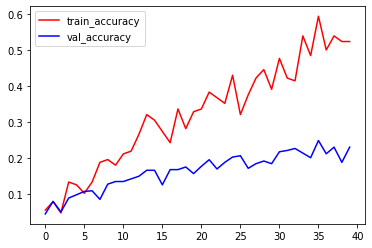

In [9]:
# Visualise train / Valid Accuracy
plt.plot(model.history.history["categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(model.history.history["val_categorical_accuracy"], c="b", label="val_accuracy")
plt.legend(loc="upper left")
plt.show()

The graph shows overfitting of the model, because the training set is twice better then the validation set is explained by less than 30%

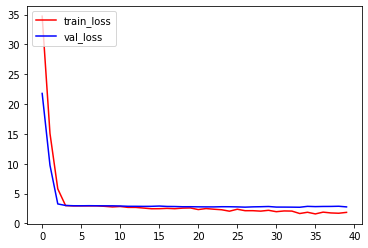

In [10]:
# Visualise train / Valid Loss
plt.plot(model.history.history["loss"], c="r", label="train_loss")
plt.plot(model.history.history["val_loss"], c="b", label="val_loss")
plt.legend(loc="upper left")
plt.show()

The loss function, on the other hand, obtained quite a similar result for the training set as well as for the validation set after the second/third epoch

In [11]:
model.evaluate(img_generator_flow_test, verbose=2)

32/32 - 11s - loss: 2.8455 - categorical_accuracy: 0.2216 - recall: 0.0519 - precision: 0.4906 - 11s/epoch - 350ms/step


[2.845473289489746,
 0.2215568870306015,
 0.05189620703458786,
 0.49056604504585266]

Overfitting may also be indicated by the fact that the test set was well characterized in only 22%

<AxesSubplot:>

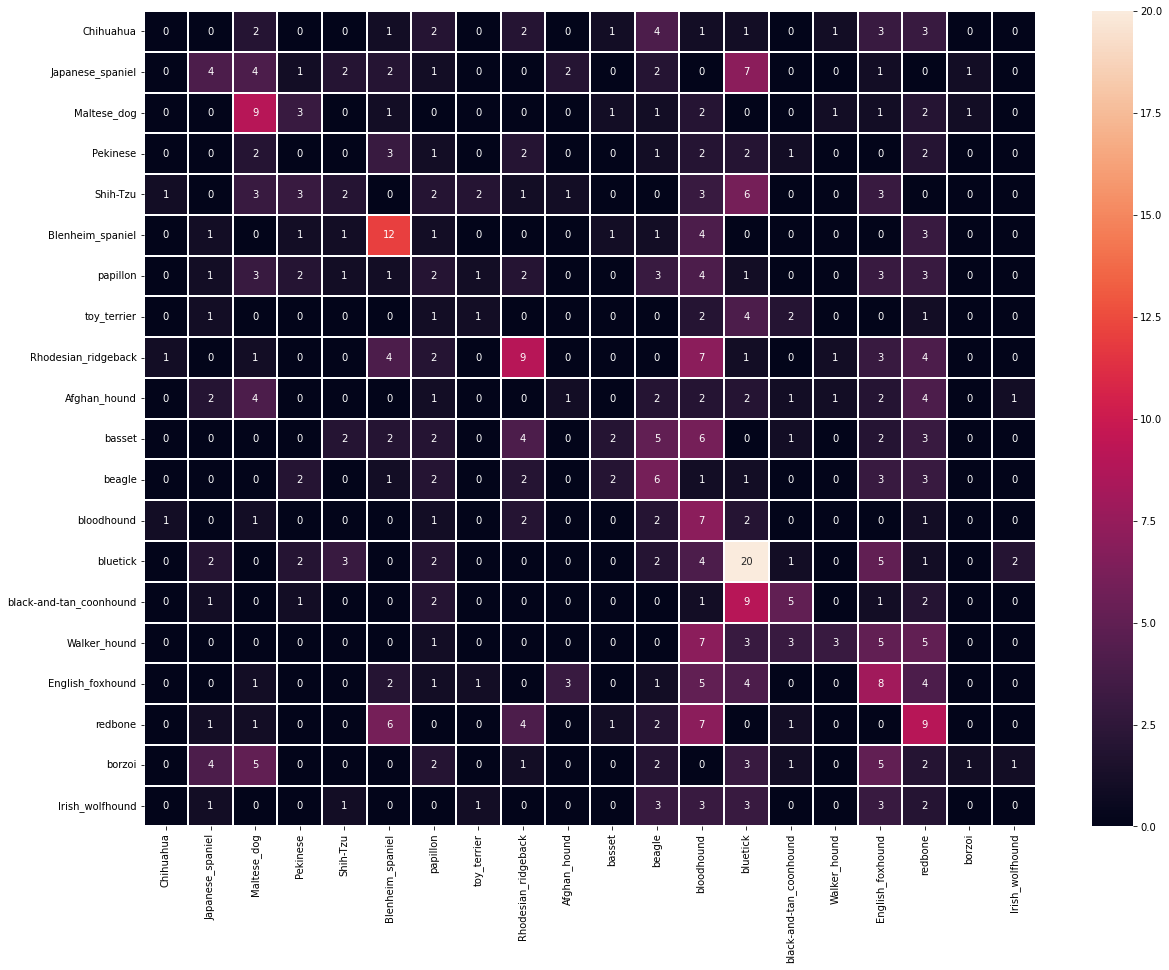

In [12]:
predictions=model.predict(img_generator_flow_test)
y = np.argmax(predictions, axis=1)
cm = confusion_matrix(img_generator_flow_test.classes, y)
df = pd.DataFrame(cm, columns=img_generator_flow_test.class_indices)
fig, ax = plt.subplots(figsize=(20,15))  
sns.heatmap(df, 
        xticklabels=df.columns,annot=True,
        yticklabels=df.columns, linewidths=.1,ax=ax)

The confusion matrix shows how many races were well classified and which races the model got wrong most often: for example  Chihuahua have 0 good classification, model classifie more often Japanese_spaniel as bluetick than correct race etc.

# Transfer learning using IncepcionV3

First, I loaded the pre-trained model (InceptionV3) on ImageNet data, using the keras package. By scaling up the input data to the data I have preprocessed and rejecting the output layer.

Then I created a model, based on the basic one, changing the input layer into the already trained model that was loaded.

The next steps are modeled on the creation of the basic model.

In [13]:
base_model = tf.keras.applications.InceptionV3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )
base_model.trainable = False
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d_1[0][0]']               
 alization)                     )                                                      

In [14]:
model_inception = tf.keras.Sequential([
    base_model,
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(dog_races), activation="softmax")
])
model_inception.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 2, 2, 2048)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 20)                163860    
                                                                 
Total params: 21,966,644
Trainable params: 163,860
Non-trainable params: 21,802,784
_________________________________________________________________


In [15]:
model_inception.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [16]:

history_inception=model_inception.fit(img_generator_flow_train, 
          validation_data=img_generator_flow_valid,
          steps_per_epoch=8, epochs=40) 

Epoch 1/40
8/8 [==============================] - 79s 10s/step - loss: 8.8522 - categorical_accuracy: 0.1484 - recall_1: 0.1406 - precision_1: 0.1782 - val_loss: 5.2912 - val_categorical_accuracy: 0.3346 - val_recall_1: 0.2684 - val_precision_1: 0.3935
Epoch 2/40
8/8 [==============================] - 71s 10s/step - loss: 5.2909 - categorical_accuracy: 0.3281 - recall_1: 0.2969 - precision_1: 0.3800 - val_loss: 4.2953 - val_categorical_accuracy: 0.3934 - val_recall_1: 0.3658 - val_precision_1: 0.4326
Epoch 3/40
8/8 [==============================] - 61s 9s/step - loss: 3.1311 - categorical_accuracy: 0.5000 - recall_1: 0.4922 - precision_1: 0.5526 - val_loss: 2.9390 - val_categorical_accuracy: 0.5129 - val_recall_1: 0.4963 - val_precision_1: 0.5533
Epoch 4/40
8/8 [==============================] - 38s 5s/step - loss: 1.9667 - categorical_accuracy: 0.5714 - recall_1: 0.5546 - precision_1: 0.6226 - val_loss: 3.1753 - val_categorical_accuracy: 0.5239 - val_recall_1: 0.5110 - val_precision_

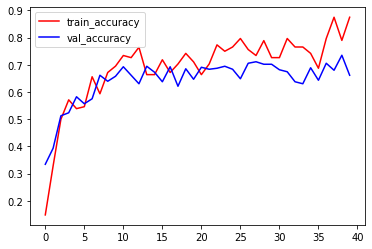

In [17]:
# Visualise train / Valid Accuracy
plt.plot(model_inception.history.history["categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(model_inception.history.history["val_categorical_accuracy"], c="b", label="val_accuracy")
plt.legend(loc="upper left")
plt.show()

Accuracy shows very good model fit to both training and validation data

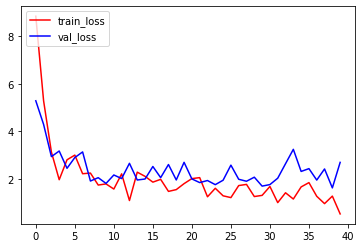

In [18]:
# Visualise train / Valid Loss
plt.plot(model_inception.history.history["loss"], c="r", label="train_loss")
plt.plot(model_inception.history.history["val_loss"], c="b", label="val_loss")
plt.legend(loc="upper left")
plt.show()

Visualization of loss shows low loss for both sets

In [19]:
model_inception.evaluate(img_generator_flow_test, verbose=2)

32/32 - 47s - loss: 2.7014 - categorical_accuracy: 0.6427 - recall_1: 0.6347 - precision_1: 0.6530 - 47s/epoch - 1s/step


[2.7013909816741943,
 0.6427145600318909,
 0.6347305178642273,
 0.6529774069786072]

Even the test data shows a good model fit of 64%

In [20]:
predictions=model_inception.predict(img_generator_flow_test)
y = np.argmax(predictions, axis=1)
cm = confusion_matrix(img_generator_flow_test.classes, y)
df = pd.DataFrame(cm, columns=img_generator_flow_test.class_indices)
df

,Chihuahua,Japanese_spaniel,Maltese_dog,Pekinese,Shih-Tzu,Blenheim_spaniel,papillon,toy_terrier,Rhodesian_ridgeback,Afghan_hound,basset,beagle,bloodhound,bluetick,black-and-tan_coonhound,Walker_hound,English_foxhound,redbone,borzoi,Irish_wolfhound
0,11,0,0,4,1,0,0,1,1,0,0,0,0,0,0,0,0,3,0,0
1,0,19,1,3,0,0,3,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,20,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,3,1,8,13,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
5,1,1,0,3,0,13,5,0,0,0,2,0,0,0,0,0,0,0,0,0
6,0,1,0,2,0,0,22,1,0,0,0,0,0,1,0,0,0,0,0,0
7,1,0,0,0,0,0,0,4,0,0,0,0,3,1,1,2,0,0,0,0
8,0,0,0,1,0,0,0,0,16,0,0,0,10,0,1,0,0,5,0,0
9,0,0,0,13,0,0,0,0,0,4,0,0,0,0,0,0,0,0,5,1


<AxesSubplot:>

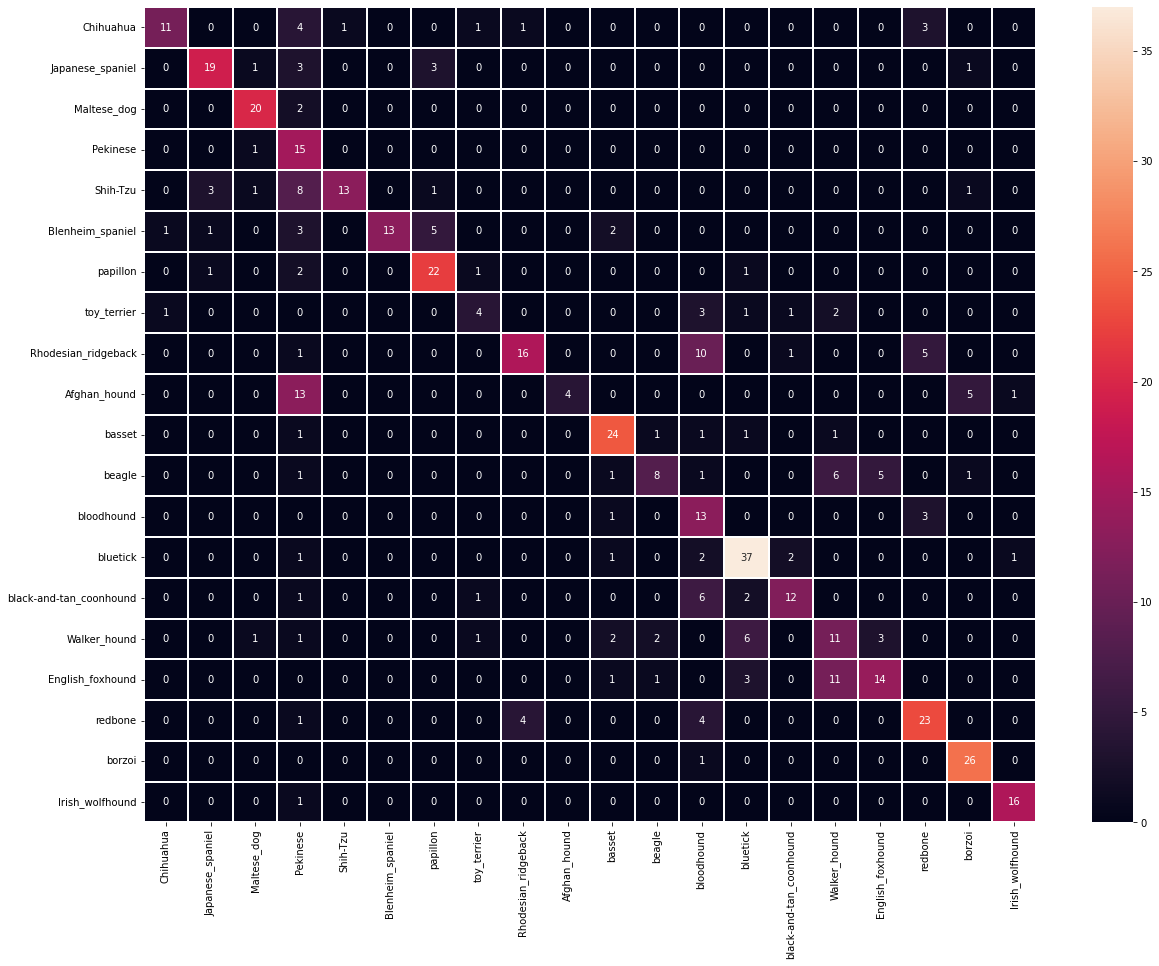

In [21]:
fig, ax = plt.subplots(figsize=(20,15))  
sns.heatmap(df, 
        xticklabels=df.columns,annot=True,
        yticklabels=df.columns, linewidths=.1,ax=ax)

The confusion matrix shows much better results: for example, there is no misclassification of all the data of a race.